# Welcome to the tutorial on numerical relativity simulations/waveforms and surrogate models!

Today we'll be covering, from a relatively zoomed out perspective:
* what numerical relativity is,
* how to load data from the `Simulating eXtreme Spacetimes Collaboration`'s catalog,
* how to build a waveform surrogate
  
So, without further ado, let's get started!

If you're working with `uv` or with `conda` and have the corresponding environment activated, then you should have the packages required for this notebook installed.

### What is SXS?

The `Simulating eXtreme Spacetimes Collaboration` is a group working to simulating Einsteins equations and provide numerical estimates of the gravitational waves we see in nature!

We'll start by working with the [`sxs`](https://pypi.org/project/sxs/) python package.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    import os
    import shutil
    if not (os.path.exists('requirements.txt') and os.path.exists('images') and os.path.exists('images')): 
        !wget https://github.com/keefemitman/SXSAndSurrogates/archive/main.zip
        !unzip main.zip
        for item in os.listdir('SXSAndSurrogates-main'):
            if not os.path.exists(item):
              shutil.move(f'SXSAndSurrogates-main/{item}', './')
        os.system('rm main.zip')
        os.system('rm -r SXSAndSurrogates-main')
    try:
        os.system('rm -r sample_data')
    except:
        pass

    !pip install -r requirements.txt

In [2]:
import sxs # this can take a second to import when doing so for the first time

`sxs` is the only way to interract with the NR simulations produced by the SXS Collaboration (or at least the only way that we *want* you to interact with out simulations).

A simulation, such as that corresponding to our favorite LVK event GW150914---SXS:BBH:0305, can be loaded via the following:

In [3]:
GW150914_simulation = sxs.load("SXS:BBH:0305")

Loading SXS simulations using latest tag 'v3.0.0', published at 2025-05-14T18:17:30Z.


This yields a `Simulations` object, which we'll dig into in more detail later. The main attributes to be aware of for now are

In [4]:
GW150914_simulation.sxs_id, GW150914_simulation.version, GW150914_simulation.Lev

('SXS:BBH:0305v3.0', 'v3.0', 'Lev6')

You'll see a few important bits of information here:
* `SXS ID`: Every simulation in our catalog (`BBH`s, `BNS`s, and `BHNS`s) comes with a unique `SXS ID` characterizing that simulation. These IDs are have no inherent meaning, but loosely correspond to the $N^{\mathrm{th}}$ simulation that we ran, i.e., larger IDs correspond to newer simulations (and thus also potentially newer versions of the NR code that produced them). Note though that more accurate information regarding the age of the simulation can be found elsewhere (we'll come to where this information is stored exactly later on).
* `version`: This, i.e., `v3.0.0`, identifies the version of the data. Unlike the SXS ID, this is an optional specifier (note that we did not specify it when loading, so we were provided with the most recent version). This is key for reproducibility!
* `Lev (resolution)`: This, i.e., `Lev5`, identifies the resolution of the simulation in some complicated way (note again that we did not specify it when loading, so we were provided with the highest resolution, i.e., the highest "Lev"). Unfortunatley, the various "Lev"s do not provide a consistent meaning across the simulations, but higher Levs for a certain simulation *will* correspond to a higher resolution version of that simulation. This is key for studying simulation accuracy!

To specify these manually, one can simply run, e.g.,

In [5]:
GW150914_simulation = sxs.load("SXS:BBH:0305v3.0/Lev6")

But what does this actually contain? Well, the main output of NR simulations is waveforms! So let's plot the gravitational wave strain $h(t,\theta,\phi)$.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

The following code grabs the strain `WaveformModes` object, which is effectively a fancy container for a 2d array of (time, spherical harmonic modes), then evaluates it at a point on the two sphere, and plots it as a function of time:

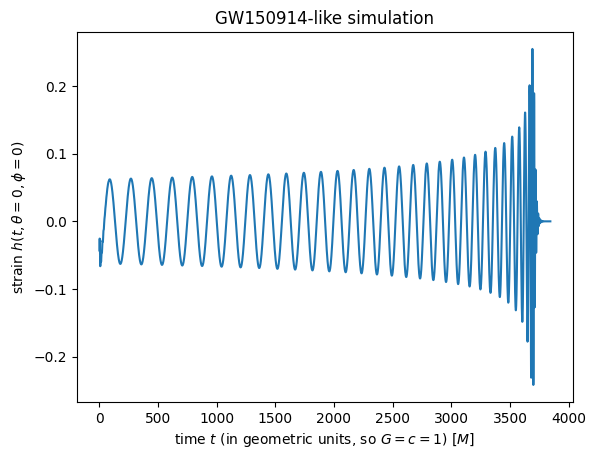

In [7]:
h = GW150914_simulation.h; theta = 0; phi = 0;
plt.plot(h.t, h.evaluate(theta, phi).real)
plt.xlabel('time $t$ (in geometric units, so $G=c=1$) $[M]$')
plt.ylabel(rf'strain $h(t,\theta={np.round(theta, 2)},\phi={np.round(phi, 2)})$')
plt.title('GW150914-like simulation');

Nice! But what is that funny feature at the very beginning of the waveform? Let's zoom in to check it out.

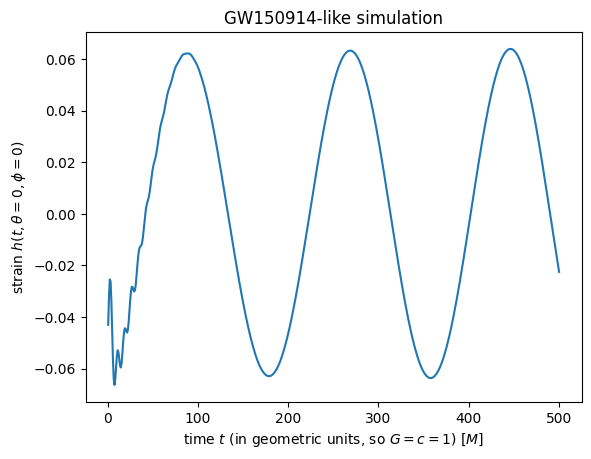

In [8]:
idx_f = np.argmin(abs(h.t - 500)) + 1
plt.plot(h.t[:idx_f], h.evaluate(theta, phi)[:idx_f].real)
plt.xlabel('time $t$ (in geometric units, so $G=c=1$) $[M]$')
plt.ylabel(rf'strain $h(t,\theta={np.round(theta, 2)},\phi={np.round(phi, 2)})$')
plt.title('GW150914-like simulation');

That doesn't look right.... shouldn't the waveform always be smooth? Or at least reasonably smooth? Maybe we should take a step back and learn a bit about numerical relativity before getting to deep!

### What is numerical relativity?

<img src="images/foliation.png" align="right" width="400" height="200">

The whole point of numerical relativity is to solve Einstein's equations:
$$
\begin{align}
G_{\mu\nu}\equiv R_{\mu\nu}-\frac{1}{2}Rg_{\mu\nu}=0,
\end{align}
$$
(because matter isn't real), which tell us what the *spacetime* looks like, by describing the metric $g_{\mu\nu}$ across the entirety of spactime. More specifically, provided some idea of the spacetime we want to study, e.g., two coalescing black holes, numerical relativity aims to "guess" what that spacetime looks like at *one time*, and then compute what it looks like at *all other times*. But how is this done?

Well, while not necessarily obvious from the above set of equations, Einstein's equations are nothing more than a series of coupled, second-order partial differential equations (PDEs). Consequently, if we are to solve these PDEs, we first want to make sure that they are well-posed, i.e., that the set of differential equations has a solution, the solution is unique, and the solution changes continuously with respect to the initial data. Fortunately for us, [Yvonne Choquet-Bruhat](https://en.wikipedia.org/wiki/Yvonne_Choquet-Bruhat) already showed us that this can be done, provided one uses the correct *gauge* 👻.

Another way to think of Einstein's equations is simply as the equations of motion stemming from some action; specifically, the Einstein-Hilbert action:
$$
\begin{align}
I=\frac{1}{16\pi}\int R\,\sqrt{-g}d^{4}x.
\end{align}
$$
When written in this form, it's easy to see that this is a *diffeomorphism invariant theory*, i.e., it is independent of the coordinates you choose. Another way to interpret this, however, is that any solution to Einstein's equations is not unique, since you can always perform a coordinate transformation to change your apparent solution. As a result, if we want to have well-posedness of our PDEs so that we can actually put them on a supercomputer and solve them, to do so we have to *fix the gauge*, i.e., we have to specify a coordinate system so that our solutions are always defined with respect to a gauge that we understand and can reference them against. (This is particularly important when comparing outputs from *different* NR codes that assume *different* gauges!)

A particulary nice choice of gauge is the *generalized harmonic* gauge:
$$
\begin{align}
\square x^{\mu}\equiv\nabla_{\nu}\nabla^{\nu}x^{\mu}=g^{\mu\nu}H_{\nu}(x,g),
\end{align}
$$
where the four functions $H_{\nu}$ can depend on the coodinate functions $x^{\mu}$ and the metric (but not derivatives of the metric; do you know why? (see below)). The reason why this gauge choice is nice is because when you write Einstein's equations in this gauge, the principal part (the part of the PDE with the highest-order derivatives) is identical to that of a scalar wave, making it much easier to evolve! (This is because the scalar wave equation is *hyperbolic*, i.e., it is much more stable against numerical error.)
$$
\begin{align}
g^{\mu\nu}\partial_{\mu}\partial_{\nu}g_{\alpha\beta}+2\nabla_{(\alpha}H_{\beta)}+(\mathrm{lower\,order\,derivative\,terms})=0.
\end{align}
$$

With our equations now written in a hyperbolic form and proven to be well-posed, one can now decompose them into space-like *foliations* (i.e., space-like hypersurfaces, see the above figure) and evolve them forward in *time* $t$ by propagating information from one $t=\mathrm{const.}$ hypersurface to the next. What this looks like mathematically is nicely summarized through the ADM formalism, which decomposes the metric rather suggestively as
$$
\begin{align}
ds^{2}=-\alpha^{2}+h_{ij}(dx^{i}+\beta^{i}dt)(dx^{j}+\beta^{j}dt),
\end{align}
$$
where $\alpha$ is the *lapse* measuring the rate of change of proper time with respect to the coordinate time $t$ of the normal observer on each hypersurface (think of it as the measure of how much curvature distorts the flow of time), $h_{ij}$ is the *instric metric* of the $t=\mathrm{const.}$ hypersurfaces, and $\beta^{j}$ is the *shift vector* describing how the spatial coordiantes change for normal observes from one hypersurface to the next.

When written in this form, it turns out that Einstein's equations naturally separate into two forms:
* *constraint* equations, which are satisfied on every $t=\mathrm{const.}$ hypersurface, and
* *evolution* equations which tell you how to evolve from on $t=\mathrm{const.}$ hypersurface to the next.

Constraint equations are used to construct initial data for the PDEs, i.e., figuring out what that first hypersurface should look like for some type of gravitational system, while the evolution equations then evole that initial data forward in time $t$.

(This is why we saw the weird features in the waveform above! It is because our initial data doesn't always perfectly satisfy the constraint equations, so one needs to wait some time for that violation of these equations to propagate out of the numerical grid and ensure that the spacetime that they are simulating matches what they expect, i.e., having the right black hole masses, spins, etc.)

By coupling this idea with the generalized harmonic gauge above, and imposing *constraint damping terms* in the PDEs (i.e., terms included to force the NR code to satisfy the constraint equations), one can then straightforwardly* evolve Einstein's equations as PDEs forward in time from one space-like hypersurface to the next, much like how one would solve a simple wave equation by solving for the full spatial profile before evoling to the next time step.

And, if you do this and write the lapse $\alpha$ to disk for each hypersurface, you can make incredible animations of this process, such as that seen in following mp4:

In [9]:
from IPython.display import Video

Video("images/simulation.mp4")

If you want to know more, there's a nice review at [arXiv:1411.3997](https://arxiv.org/abs/1411.3997); or if you want to see a part of history, check out Frans Pretorious' first successful BBH simulation at [arXiv:0507014](https://arxiv.org/abs/gr-qc/0507014)!

### Waveforms from numerical relativity

Above, we gave a brief overview of how one formulates Einstein's equations as well-posed PDEs such that they can be evolved on a supercomputer to obtain the metric $g_{\mu\nu}$ and it's derivatives on some finite region of spacetime.

But what do we really want at the end of the day from these simulations? Is it the metric or something else? Naturally we're all probably thinking we want waveforms, since that's what the data that the LVK Collaboration observes looks like. And, as expected, that intuition is correct! We really do want waveforms. But what's the more fundamental reason *for* wanting waveforms? The answer is twofold:
* First, imagine the SXS Collaboration simply provided the metric $g_{\mu\nu}$ over the spacetime folation $\Sigma$, i.e., the union of the spacelike hypersurfaces discussed above. That would be A LOT of data! And it would make the parameter estimation for any observation an absolute nightmare, because the four-dimensional data would be way more expensive to work with than the two-dimensional waveforms we're familiar with.
* More importantly, though, that metric data would be incredibly *gauge dependent*! If we decided to change our coordinates arbitrarily as we're allowed to due to the diffeomorphism-invariance of GR via $x'^{\mu}=x^{\mu}+\xi^{\mu}$, we would have a completely new metric $g'^{\mu\nu}=g_{\mu\nu}-2\nabla_{(\mu}\xi_{\nu)}$! How would we ever decide how to pick from the infinite number of coordinates that we could rightfully choose from???

What's amazing about waveforms, or, more specifically, *extracting data at future null infinity* $\mathcal{I}^{+}$---the boundary of asymptotically flat spacetimes---is that it has a specific structure, which highly limits the number of coordinate systems that one can choose from since the only coordinates one is allowed to work with are those that preserve the specific structure of $\mathcal{I}^{+}$!.

In particular, if one writes down the metric describing asymptotic radiation, i.e., gravitational waves, they obtain the Bondi-Sachs metric:
$$
\begin{align}
ds^{2}&=-Ue^{2\beta}du^{2}-2e^{2\beta}dudr\nonumber\\
&\phantom{=.}+r^{2}\gamma_{AB}(d\theta^{A}-\mathcal{U}^{A}du)(d\theta^{B}-\mathcal{U}^{B}du),
\end{align}
$$
where $A,B\in\{1,2\}$ and $U$, $\beta$, $\mathcal{U}^{A}$, and $\gamma_{AB}$ are functions of $u\equiv t-r$ (the retarded time), $r$, and $\theta^{A}$. Each of these functions has an asymptotic expansion, but the one we will be primarily concerned with is that of $\gamma_{AB}$, which is
$$
\begin{align}
\gamma_{AB}=q_{AB}+\frac{1}{r}C_{AB}+\frac{1}{r^{2}}D_{AB}+\cdots
\end{align}
$$
In this expansion, $q_{AB}$ is just the usual round metric on the two-sphere, but $C_{AB}$, the *shear tensor*, represents the leading order correction to the background due to gravitational waves! This tensor is related to the gravitational wave strain observable, $h$, via
$$
\begin{align}
h=\frac{1}{2}\bar{q}^{A}\bar{q}^{B}C_{AB}=\sum\limits_{\ell\geq2, |m|\leq\ell}h_{(\ell,m)}(u)\phantom{}_{-2}Y_{(\ell,m)}(\theta,\phi),
\end{align}
$$
where $q_{A}=-(1,i\sin(\theta))$ is a complex dyad (i.e., a pair of spinors) on the two-sphere. This is why the strain is represented by spin-weight $-2$ spherical harmonics, because it is the contraction of a dyad with a tensor on the celestial two-sphere! Note that, more physically, one can also connect the presence of two dyads in the contraction as being directly related to the fact that the strain has two polarizations, $h_{+}$ and $h_{\times}$.

Immediately, one might be concerned that by only considering $C_{AB}$ and neglecting higher-order corrections like $D_{AB}$ we may be biasing our physical analyses. Fortunately, though, for typical LVK luminosity distances on the order of a few hundred Mpcs, the next leading-order corrections are of magnitude $10^{-20}$ below that of $C_{AB}$! (Check it for yourself!) So this approximation really is a completely valid description of the metric perturbations that we observe in our detectors.

But how do we extract this from NR simulations? There's two methods for doing this:
* *extrapolation*, and
* *Cauchy-characteristic evolution (CCE)*.

The first simply fits the metric $g_{\mu\nu}$ with polynomials in $1/r$ in the numerical spacetime and takes the $1/r$ coefficient as $C_{AB}$. This is how almost all publicly-available waveforms are computed.

The second instead performs a second evolution of Einstein's equations, but now on light-like slices that connect the finite simulation volume to future null infinity by compacting the radial coordinate so that $\mathcal{I}^{+}$ can actually be included in the numerical grid! Obviously this method is much better, but it is certainly more complicated, so it is taking time to make this data publicly available, but the SXS Collaboration is currently working on this.

Ok, with the theory out of the way, let's look at some waveforms!

### Working with the [`sxs`](https://pypi.org/project/sxs/) package

As mentioned earlier, the [`sxs`](https://pypi.org/project/sxs/) package is the main (and really only) way to interact with the [`SXS Collaboration`'s catalog of simulations](https://arxiv.org/abs/2505.13378).

However, using this package isn't fool proof! You still need to be aware of some of the physics. In particular, if you didn't know that the initial data of NR simulations wasn't perfect and included the early part of the waveform which contains this "junk radiation" in your gravitaitonal wave analysis, you could obtain nonsensical results. While we've done our best to take care of some of the other nuisances involved with waveforms (e.g., putting the waveforms in some reasonable gauge), the user still has to do a little bit of work, such as removing the early portion of the waveform that contains "junk" and potentially even changing the gauge to match the analysis that they'd like to conduct.

#### Working with individual simulations

Each `Simulations` object has a `Metadata` object as an attribute which stores metadata about the simulation.

In [10]:
GW150914_simulation.metadata

Metadata([('simulation_name',
           'BBH_SKS_d14.3_q1.22_sA_0_0_0.330_sB_0_0_-0.440/Lev6'),
          ('keywords', []),
          ('alternative_names', ['PRIVATE:BBH:0225', 'SXS:BBH:0305']),
          ('metadata_format_revision', 2),
          ('metadata_content_revision', 1),
          ('internal_minor_version', 0),
          ('internal_changelog', {}),
          ('citation_dois', ['10.1088/1361-6382/ab34e2']),
          ('initial_separation', 14.2600708008),
          ('initial_orbital_frequency', 0.016961605632),
          ('initial_adot', -5.30625362797e-05),
          ('initial_ADM_energy', 0.9923541855108845),
          ('initial_ADM_linear_momentum',
           [-5.04414e-11, 1.116714e-10, 5.9e-14]),
          ('initial_ADM_angular_momentum',
           [3.385e-13, -1.0649e-12, 1.0829620209826503]),
          ('initial_dimensionless_spin1',
           [3.2772e-12, -9.165e-13, 0.3300000041229183]),
          ('initial_dimensionless_spin2',
           [-2.778e-13, -1.44e-13, 

There's a lot of information here, such as the black hole masses, spins, eccentricity, mean anomaly, and orbital frequency for the initial data (labeled `initial`) or at some `reference_time` which is some time at which the junk radiation has been deemed to have predominantly left the system. There's also the time of the common horizon formation, the number of orbits, mass and spin information about the remnant black hole, and much more. When cutting the waveform, one wants to use the `relaxation_time` (which is effectively identical to the `reference_time`). Note that this is a very conservative choice, so it may cut out more than needed, as seems to be the case here! (See [arXiv:2407.20470](https://arxiv.org/abs/2407.20470) for more details).

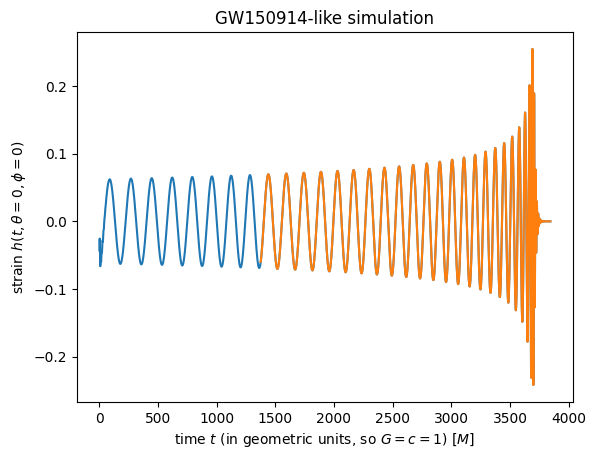

In [11]:
h = GW150914_simulation.h; theta = 0; phi = 0; psi = 0.

idx_relax = np.argmin(abs(h.t - GW150914_simulation.metadata['relaxation_time']))

plt.plot(h.t, h.evaluate(theta, phi, psi).real)
plt.plot(h.t[idx_relax:], h.evaluate(theta, phi, psi)[idx_relax:].real)
plt.xlabel('time $t$ (in geometric units, so $G=c=1$) $[M]$')
plt.ylabel(rf'strain $h(t,\theta={np.round(theta, 2)},\phi={np.round(phi, 2)})$')
plt.title('GW150914-like simulation');

If one wants to look at individal harmonics, like the $(2,2)$ mode, one can do so via:

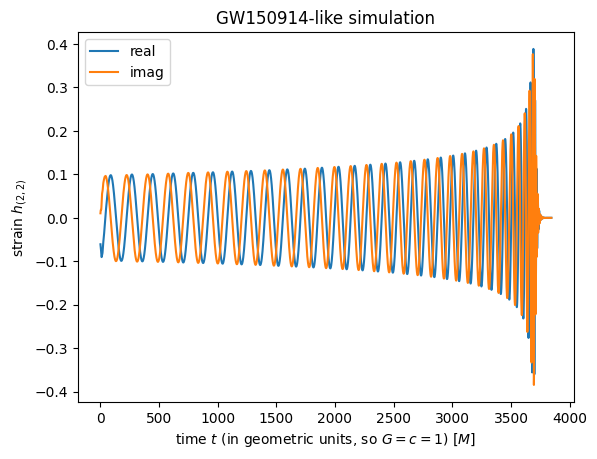

In [12]:
h = GW150914_simulation.h; L = 2; M = 2;

plt.plot(h.t, h.data[:,h.index(L, M)].real, label='real')
plt.plot(h.t, h.data[:,h.index(L, M)].imag, label='imag')
plt.xlabel('time $t$ (in geometric units, so $G=c=1$) $[M]$')
plt.ylabel(r'strain $h_{(' + str(L) + ',' + str(M) + r')}$')
plt.title('GW150914-like simulation')
plt.legend();

Or they could even look at all harmonics via:

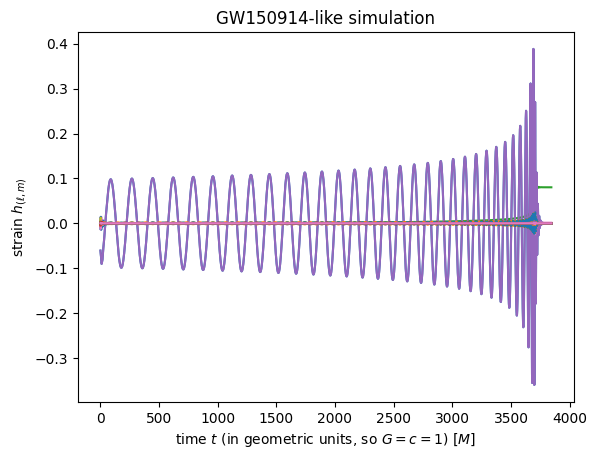

In [13]:
h = GW150914_simulation.h;

plt.plot(h.t, h.data.real)
plt.xlabel('time $t$ (in geometric units, so $G=c=1$) $[M]$')
plt.ylabel(r'strain $h_{(\ell, m)}$')
plt.title('GW150914-like simulation');

(⭐️ Bonus: what's with the funny offsets at the end???)

And, apart from waveforms, one can also study the horizons via the `Horizons` object to, e.g., study the orbital motion:

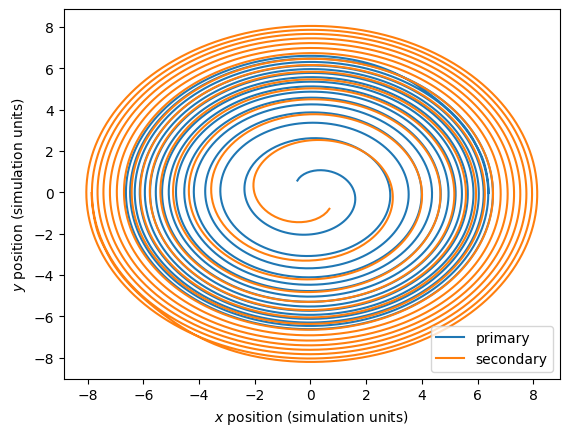

In [14]:
x_A = GW150914_simulation.Horizons.A.coord_center_inertial
x_B = GW150914_simulation.Horizons.B.coord_center_inertial

plt.plot(x_A[:,0], x_A[:,1], label='primary')
plt.plot(x_B[:,0], x_B[:,1], label='secondary')
plt.xlabel(r'$x$ position (simulation units)')
plt.ylabel(r'$y$ position (simulation units)')
plt.legend();

Or the mass evolution:

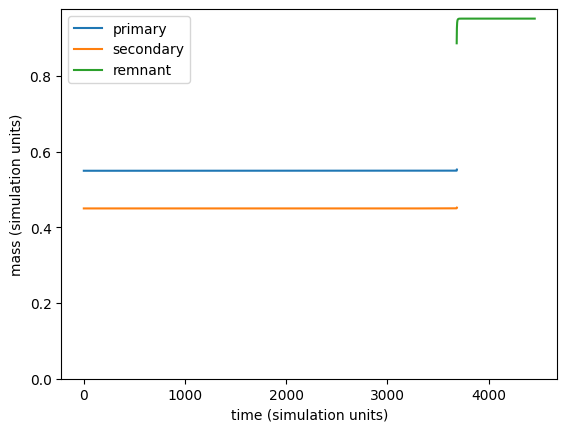

In [15]:
m_A = GW150914_simulation.Horizons.A.christodoulou_mass
m_B = GW150914_simulation.Horizons.B.christodoulou_mass
m_C = GW150914_simulation.Horizons.C.christodoulou_mass

plt.plot(GW150914_simulation.Horizons.A.time, m_A, label=r"primary")
plt.plot(GW150914_simulation.Horizons.B.time, m_B, label=r"secondary")
plt.plot(GW150914_simulation.Horizons.C.time, m_C, label=r"remnant")
plt.ylabel(r"mass (simulation units)")
plt.xlabel(r"time (simulation units)")
plt.ylim(bottom=0.0)
plt.legend();

Or the spins:

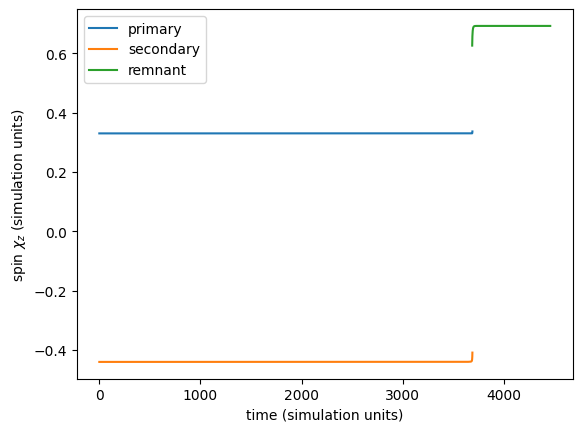

In [55]:
s_A = GW150914_simulation.Horizons.A.chi_inertial
s_B = GW150914_simulation.Horizons.B.chi_inertial
s_C = GW150914_simulation.Horizons.C.chi_inertial

plt.plot(GW150914_simulation.Horizons.A.time, s_A[:,2], label=r"primary")
plt.plot(GW150914_simulation.Horizons.B.time, s_B[:,2], label=r"secondary")
plt.plot(GW150914_simulation.Horizons.C.time, s_C[:,2], label=r"remnant")
plt.ylabel(r"spin $\chi_{z}$ (simulation units)")
plt.xlabel(r"time (simulation units)")
plt.legend();

For details on how these are computed, see Eqs. (1) - (6) of [arXiv:1904.04831](https://arxiv.org/pdf/1904.04831).

Last, you may also be interested in how accrate the simulation you're looking at is. For this, `sxs` provides the `sxs.simulations.analyze.analyze_simulation` function.

Unfortunately this takes a while to run (since it performs optimizations to align waveforms of different resolutions), so we won't do so here, but feel free to run it on your own time and check out the documentation via `help(sxs.simulations.analyze.analyze_simulation)` (or the catalog paper, [arXiv:2505.13378](https://arxiv.org/abs/2505.13378)) for details on what the returned errors are!

In [16]:
#analysis = sxs.simulations.analyze.analyze_simulation("SXS:BBH:0305")

#### Working with more than one simulation

Often though, one many not know what specific SXS ID they want to work with! Instead, they're probably more likely just interested in some part of parameter space, e.g., some mass ratio and some spins. For this, we encourage users to first interface with the [SXS Catalog Website](https://data.black-holes.org/simulations/index.html) (which can sometimes take a second to load, because it's running python in your browser!): an interactive browser for searching through our catalog with ease.

<img src="images/marimo.png" width="800" height="200">

On the website, let's try to get some quasi-circular, non-spinning simulations. We'll select `BBH`, `noneccentric`, `nonprecessing`, and `undeprecated` and then add further filers on `reference_chi1_mag`$\leq0.01$ and `reference_chi2_mag`$\leq0.01$.

This results in the following 73 simulations:

In [17]:
import sxs
df = sxs.load("dataframe", tag="v3.0.0")
sims = [sxs.load(sxs_id) for sxs_id in [
    "SXS:BBH:0185", "SXS:BBH:0186", "SXS:BBH:0188", "SXS:BBH:0189", "SXS:BBH:0192", "SXS:BBH:0195",
    "SXS:BBH:0198", "SXS:BBH:0199", "SXS:BBH:0201", "SXS:BBH:0310", "SXS:BBH:0389", "SXS:BBH:0593",
    "SXS:BBH:1108", "SXS:BBH:1132", "SXS:BBH:1142", "SXS:BBH:1143", "SXS:BBH:1153", "SXS:BBH:1154",
    "SXS:BBH:1155", "SXS:BBH:1166", "SXS:BBH:1167", "SXS:BBH:1178", "SXS:BBH:1179", "SXS:BBH:1220",
    "SXS:BBH:1221", "SXS:BBH:1222", "SXS:BBH:1354", "SXS:BBH:1906", "SXS:BBH:2164", "SXS:BBH:2265",
    "SXS:BBH:2325", "SXS:BBH:2326", "SXS:BBH:2331", "SXS:BBH:2374", "SXS:BBH:2375", "SXS:BBH:2376",
    "SXS:BBH:2377", "SXS:BBH:2378", "SXS:BBH:2425", "SXS:BBH:2477", "SXS:BBH:2480", "SXS:BBH:2483",
    "SXS:BBH:2484", "SXS:BBH:2485", "SXS:BBH:2486", "SXS:BBH:2487", "SXS:BBH:2488", "SXS:BBH:2489",
    "SXS:BBH:2490", "SXS:BBH:2491", "SXS:BBH:2492", "SXS:BBH:2493", "SXS:BBH:2494", "SXS:BBH:2495",
    "SXS:BBH:2496", "SXS:BBH:2497", "SXS:BBH:2498", "SXS:BBH:2499", "SXS:BBH:2516", "SXS:BBH:2707",
    "SXS:BBH:3144", "SXS:BBH:3617", "SXS:BBH:3619", "SXS:BBH:3622", "SXS:BBH:3624", "SXS:BBH:3630",
    "SXS:BBH:3631", "SXS:BBH:3632", "SXS:BBH:3633", "SXS:BBH:3634", "SXS:BBH:3864", "SXS:BBH:3984",
    "SXS:BBH:4434"
]]
qs = [sim.metadata.reference_mass_ratio for sim in sims]
# here I truncate the waveforms to only be 1000M of inspiral + 50M of ringdown for simplicity
hs = [sim.h[np.argmin(abs(sim.h.t - (sim.h.max_norm_time() - 1000))):np.argmin(abs(sim.h.t - (sim.h.max_norm_time() + 50))) + 1] for sim in sims]
hs = [x for _, x in sorted(zip(qs, hs))]
qs = sorted(qs)

We can plot the waveforms via:

In [18]:
import matplotlib.cm as cm
import matplotlib.colors as colors

/var/folders/63/h_06fwvj5_v_gyn7d32k4dbm0000gn/T/ipykernel_17041/1550825977.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


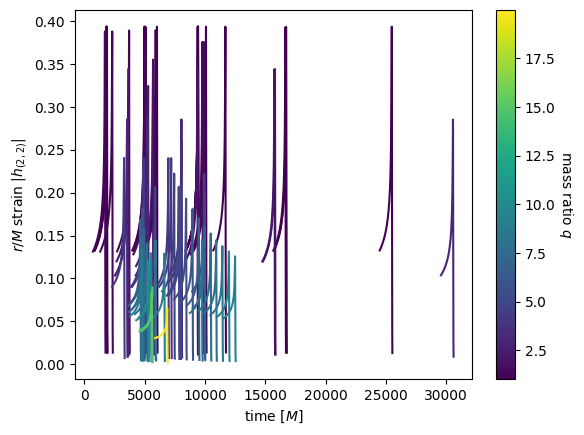

In [19]:
norm = colors.Normalize(vmin=min(qs), vmax=max(qs))
cmap = cm.get_cmap('viridis')

for i, h in enumerate(hs):
    plt.plot(h.t, abs(h.data[:,h.index(2,2)]), color=cmap(norm(qs[i])))
plt.xlabel(r'time $[M]$')
plt.ylabel(r'$r/M$ strain $|h_{(2,2)}|$')
res = plt.scatter([None]*len(hs), [None]*len(hs), c=np.array(qs), vmin=min(qs), vmax=max(qs), cmap='viridis')
c = plt.colorbar(res)
c.set_label('mass ratio $q$', rotation=270, labelpad=14);

Ah shoot! These waveforms are all in coordinates where the peaks are not aligned! Let's change the coordinates so $t=0$ corresponds to the time of max $L^{2}$ norm of the strain over the two-sphere.

In [20]:
for h in hs:
    # interpolate here interpolates the finitely sampled NR data to a spline, and then computes the maximum of that spline for a better prediction
    h.t = h.t - h.max_norm_time(interpolate=True)

/var/folders/63/h_06fwvj5_v_gyn7d32k4dbm0000gn/T/ipykernel_17041/4225419889.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


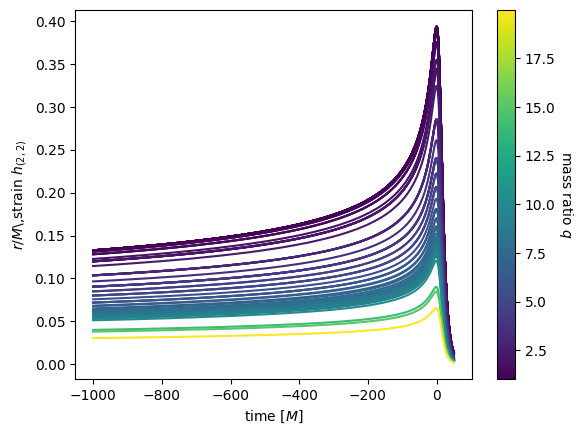

In [21]:
norm = colors.Normalize(vmin=min(qs), vmax=max(qs))
cmap = cm.get_cmap('viridis')

for i, h in enumerate(hs):
    plt.plot(h.t, abs(h.data[:,h.index(2,2)]), color=cmap(norm(qs[i])))
plt.xlabel(r'time $[M]$')
plt.ylabel(r'$r/M$\,strain $h_{(2,2)}$')
res = plt.scatter([None]*len(hs), [None]*len(hs), c=np.array(qs), vmin=min(qs), vmax=max(qs), cmap='viridis')
c = plt.colorbar(res)
c.set_label('mass ratio $q$', rotation=270, labelpad=14);

Much better! What about if we include the phase information?

/var/folders/63/h_06fwvj5_v_gyn7d32k4dbm0000gn/T/ipykernel_17041/1092660378.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')
/Users/keefemitman/Desktop/CCA_tutorial/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/keefemitman/Desktop/CCA_tutorial/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


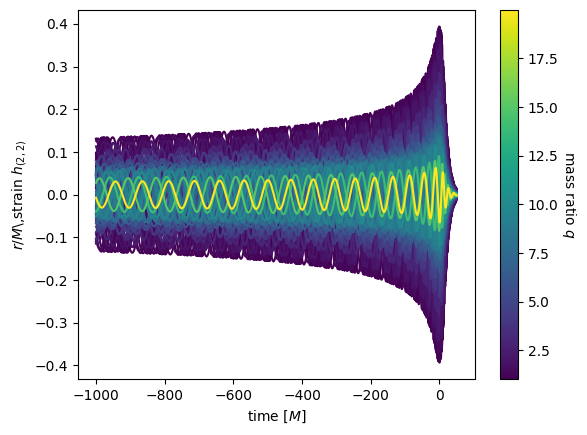

In [22]:
norm = colors.Normalize(vmin=min(qs), vmax=max(qs))
cmap = cm.get_cmap('viridis')

for i, h in enumerate(hs):
    plt.plot(h.t, h.data[:,h.index(2,2)], color=cmap(norm(qs[i])))
plt.xlabel(r'time $[M]$')
plt.ylabel(r'$r/M$\,strain $h_{(2,2)}$')
res = plt.scatter([None]*len(hs), [None]*len(hs), c=np.array(qs), vmin=min(qs), vmax=max(qs), cmap='viridis')
c = plt.colorbar(res)
c.set_label('mass ratio $q$', rotation=270, labelpad=14);

Yuck! But of course! We haven't fixed the angular freedom of our coordinates! Let's do this by making the phase of $(2,2)$ zero and the real part of $(3,3)$ positive at $t=-1000M$.

(⭐️ Bonus: why do we need make the real part of $(3,3)$ positive???)

In [23]:
import quaternionic

In [24]:
for i, h in enumerate(hs):
    d_phase = np.angle(h.data[0,h.index(2,2)])/2
    if (h.data[0,h.index(3,3)] * np.exp(-1j * 3 * d_phase)).real < 0:
        d_phase += np.pi
        
    hs[i] = h.rotate(
        quaternionic.array.from_axis_angle(
            [0., 0., -d_phase]
        )
    )

/var/folders/63/h_06fwvj5_v_gyn7d32k4dbm0000gn/T/ipykernel_17041/1329997155.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


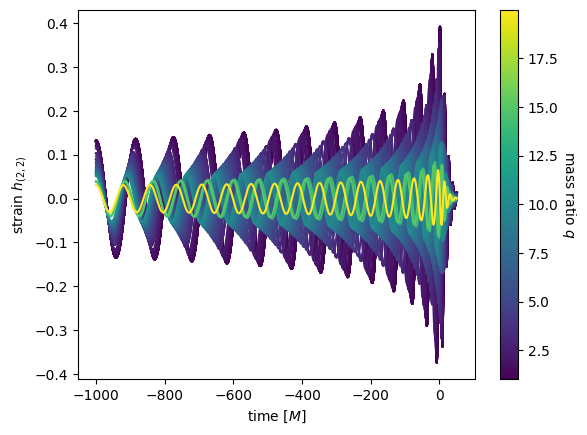

In [25]:
norm = colors.Normalize(vmin=min(qs), vmax=max(qs))
cmap = cm.get_cmap('viridis')

for i, h in enumerate(hs):
    plt.plot(h.t, h.data[:,h.index(2,2)], color=cmap(norm(qs[i])))
plt.xlabel(r'time $[M]$')
plt.ylabel(r'strain $h_{(2,2)}$')

res = plt.scatter([None]*len(hs), [None]*len(hs), c=np.array(qs), vmin=min(qs), vmax=max(qs), cmap='viridis')
c = plt.colorbar(res)
c.set_label('mass ratio $q$', rotation=270, labelpad=14);

Much better! There's still certainly some complexity, i.e., the phases evolve at different rates, but this looks much smoother as a function of `q` than before!

(⭐️ Bonus: can you think of a way to scale the vertical and horizontal axes to make the waveforms more similar?)

Now, although we have waveforms at many mass ratios...

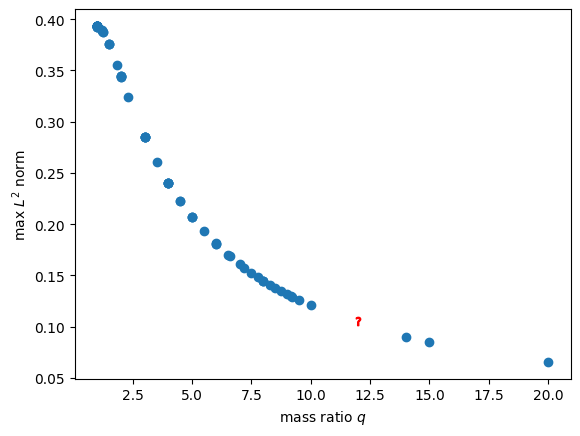

In [26]:
plt.scatter(qs, [max(abs(h.data[:,h.index(2,2)])) for h in hs])
plt.scatter(12, 0.105, marker=r'$?$', color='red')
plt.xlabel('mass ratio $q$')
plt.ylabel('max $L^{2}$ norm');

what if we *reeaaaally* want the waveform at $q=12$? Is there a way to *interpolate* the waveform data across the mass ratio parameter space?

### Introduction to surrogate modeling

When building a surrogate model, the most important thing is obtaining a nice set of training data, e.g., the NR simulations we were plotting above. Then, the main steps to building a successful model are:
1. map the training data to be in the same *gauge*, i.e., use a common set of coordinates on $\mathcal{I}^{+}$
  * this not only involves fixing the gauge like we did above (with the time/phase fixing), but also ensuring a common set of sparse coordinate values (e.g., common time arrays)
2. decompose the complex $h_{(\ell,m)}(t)$ data into data that is easier to model, like amplitude and phase
3. build a basis of time-dependent functions to model the training data with
4. build interpolants for the basis function coefficients across parameter space

Put differently, we're trying to build a model of the strain $h(t,\theta,\phi;\vec{\Lambda})$ (where $\vec{\Lambda}$ are the intrinsic parameters---like mass ratio $q$---that our waveforms depend on) as:
$$
\begin{align}
h(t,\theta,\phi;\vec{\Lambda})=\sum\limits_{\ell\geq2,|m|\leq\ell}\left(\sum\limits_{i=1}^{N}c_{i}(\vec{\Lambda})u_{i}(t)\right)\phantom{}_{-2}Y_{(\ell,m)}(\theta,\phi),
\end{align}
$$
where $\phantom{}_{-2}Y_{(\ell,m)}(\theta,\phi)$ are the usual spin-weight $-2$ spherical harmonics, $u_{i}(t)$ are our temporal basis functions, and $c_{i}(\vec{\Lambda})$ are the coefficients weighting $u_{i}(t)$ as a function of our intrinsic parameters $\vec{\Lambda}$.

#### step 1: preparing training data

We've already done the first part of step 1, i.e., fixing the gauge by aligning in time and phase, so now let's map our waveforms to a common time array.

In [27]:
t_common = np.arange(-1000, 50, 0.1)
for i, h in enumerate(hs):
    hs[i] = h.interpolate(t_common)

#### step 2: data decomposition

Clearly an oscillatory function like $h_{(\ell,m)}$ will be hard to model, so let's decompose it into amplitude and phase which should be smoother across $q$.

In [28]:
As = np.array([abs(h.data[:,h.index(2,2)]) for h in hs])
phis = np.array([np.unwrap(np.angle(h.data[:,h.index(2,2)])) for h in hs])

/var/folders/63/h_06fwvj5_v_gyn7d32k4dbm0000gn/T/ipykernel_17041/532332312.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


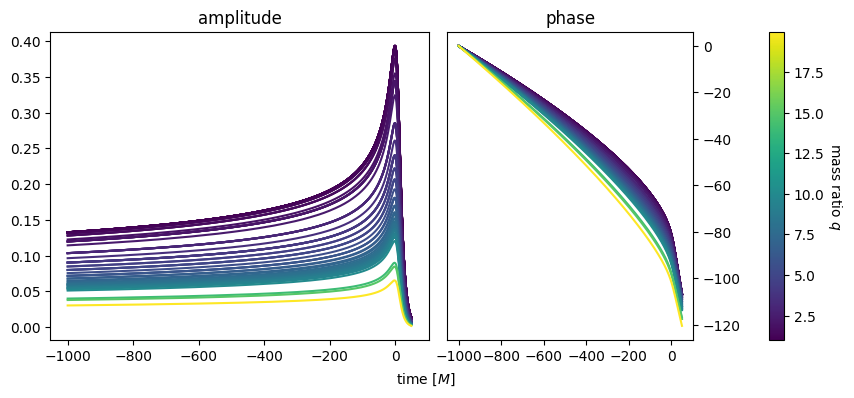

In [29]:
norm = colors.Normalize(vmin=min(qs), vmax=max(qs))
cmap = cm.get_cmap('viridis')

fig, axis = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
plt.subplots_adjust(wspace=0.05)

for i in range(len(As)):
    axis[0].plot(t_common, As[i], color=cmap(norm(qs[i])))
    axis[1].plot(t_common, phis[i], color=cmap(norm(qs[i])))
axis[1].yaxis.tick_right()
axis[0].set_title('amplitude')
axis[1].set_title('phase')
fig.text(0.5, 0.0, r'time $[M]$', ha='center')

res = plt.scatter([None]*len(qs), [None]*len(qs), c=np.array(qs), vmin=min(qs), vmax=max(qs), cmap='viridis')
c = plt.colorbar(res, pad=0.2)
c.set_label('mass ratio $q$', rotation=270, labelpad=14);

#### step 3a: building a basis with Singular Value Decomposition

At this point, we now have two $(10500, 73)$ matrices (time $\times$ mass ratio): one for amplitudes and one for phases, and we want to find a basis which represents these two data sets well.

Naturally, the most obvious thing to try is using Singular Value Decomposition (SVD) to find the most important "modes" of the data, i.e., the basis which does the best at modeling the columns of our data matrices when combined in some linear fashion. Constructing the SVD of some matrix simply amounts to rewriting that matrix, call it $L$, as the product of three matrices
$$
L=U\cdot\Sigma\cdot V^{\dagger},
$$
where $U$ is an $m\times m$ complex unitary matrix, $\Sigma$ is an $m\times n$ rectangular diagonal matrix with non-negative real numbers on the diagonal, $V$ is an $n\times n$ complex unitary matrix, with $V^{\dagger}$ is conjugate transpose. When written in this key form, the columns of $U$ tell us the most important basis vectors, while the $i^{\mathrm{th}}$ diagonal element of $\Sigma$ tell us how important the $i^{\mathrm{th}}$ column of $U$ is to our basis. So what's our basis?

Let's begin by computing the SVDs of each data set.

In [85]:
u_As, s_As, vh_As = np.linalg.svd(As.T)
u_phis, s_phis, vh_phis = np.linalg.svd(phis.T)

Clearly there are some features in our data which are shared broadly across our data set, while there are some other features that are much less important.

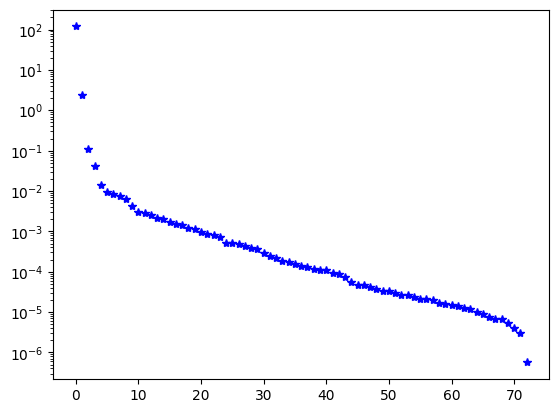

In [86]:
plt.semilogy(range(len(As)), s_As, 'b*');

And the first few basis functions look like what we'd expect!

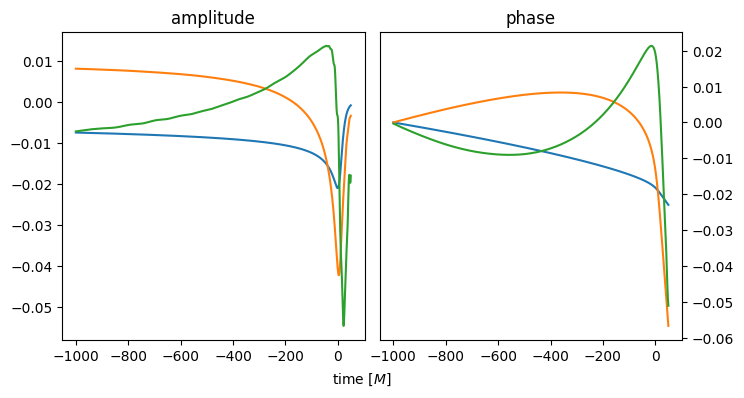

In [87]:
fig, axis = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
plt.subplots_adjust(wspace=0.05)

for i in range(3):
    axis[0].plot(t_common, u_As[:,i])
    axis[1].plot(t_common, u_phis[:,i])
axis[1].yaxis.tick_right()
axis[0].set_title('amplitude')
axis[1].set_title('phase')
fig.text(0.5, 0.0, r'time $[M]$', ha='center');

In [88]:
from sklearn.decomposition import FastICA

In [122]:
transformer = FastICA(
    n_components=None,
    random_state=0,
    whiten='unit-variance'
)
As_transformed = transformer.fit_transform(As)

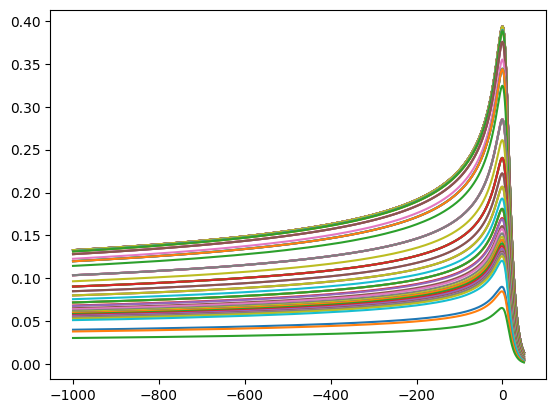

In [128]:
plt.plot(t_common, As.T);

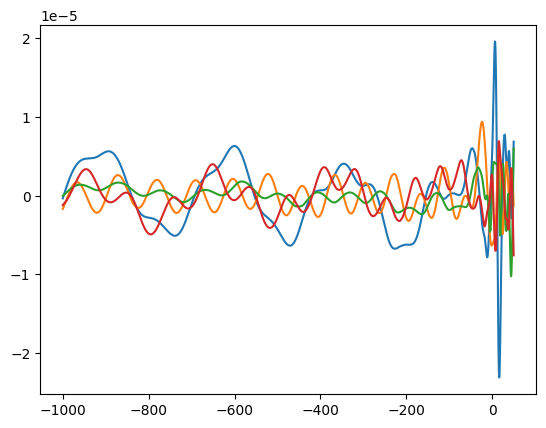

In [130]:
plt.plot(t_common, transformer.mixing_[:,:4])

But how well does this basis actually model our training data? To check this, we can compute the projection coefficients of a finite number of basis functions against one element of our training data set and compute what the residual between the approximation stemming from our SVD and the training data is. (⭐️ Bonus: how might you evaluate the success of your approximation even more robustly?).

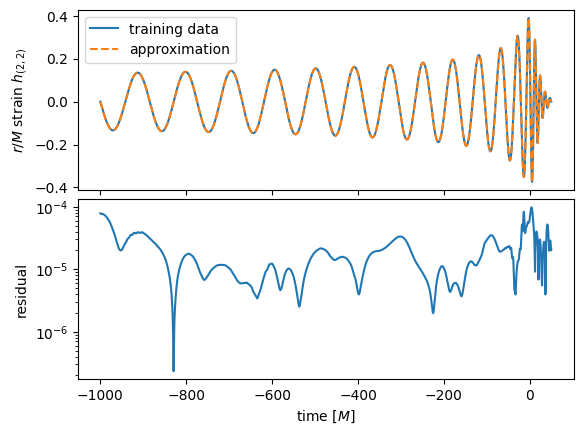

In [33]:
# Choose some number of basis functions and pick out the corresponding basis functions
A_basis_size = 7
phi_basis_size = 7

A_basis_set = u_As[:, 0:A_basis_size]
phi_basis_set = u_phis[:, 0:phi_basis_size]

# Choose one of our training waveforms
idx_test = 10

# Compute its representation in the linear space defined by the space of our basis
proj_coeffs_A = np.dot(A_basis_set.conjugate().transpose(), As[idx_test])
A_approx = np.dot(A_basis_set, proj_coeffs_A.transpose()).transpose()

proj_coeffs_phi = np.dot(phi_basis_set.conjugate().transpose(), phis[idx_test])
phi_approx = np.dot(phi_basis_set, proj_coeffs_phi.transpose()).transpose()

fig, axis = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=0.05)

axis[0].plot(t_common, hs[idx_test].data[:,hs[idx_test].index(2,2)].imag, label='training data')
axis[0].plot(t_common, A_approx * np.exp(1j * phi_approx).imag, ls='--', label='approximation')
axis[1].semilogy(t_common, abs(hs[idx_test].data[:,hs[idx_test].index(2,2)] - A_approx * np.exp(1j * phi_approx)))
axis[0].legend()
axis[0].set_ylabel(r'$r/M$ strain $h_{(2,2)}$')
axis[1].set_xlabel(r'time $[M]$')
axis[1].set_ylabel('residual');

Not bad! But can we do better? In particular, are we sure we chose the right number of basis functions?

To assess this, we can simply increase the number of basis functions and see at what point our errors start to plateau.

In [34]:
def modeling_error(number_of_basis_functions):
    # Choose some number of basis functions and pick out the corresponding basis functions
    A_basis_size = number_of_basis_functions
    phi_basis_size = number_of_basis_functions
    
    A_basis_set = u_As[:, 0:A_basis_size]
    phi_basis_set = u_phis[:, 0:phi_basis_size]
    
    # Choose one of our training waveforms
    idx_test = 10
    
    # Compute its representation in the linear space defined by the space of our basis
    proj_coeffs_A = np.dot(A_basis_set.conjugate().transpose(), As[idx_test])
    A_approx = np.dot(A_basis_set, proj_coeffs_A.transpose()).transpose()
    
    proj_coeffs_phi = np.dot(phi_basis_set.conjugate().transpose(), phis[idx_test])
    phi_approx = np.dot(phi_basis_set, proj_coeffs_phi.transpose()).transpose()

    return (
        np.linalg.norm(A_approx - abs(hs[idx_test].data[:,hs[idx_test].index(2,2)])),
        np.linalg.norm(phi_approx - np.unwrap(np.angle(hs[idx_test].data[:,hs[idx_test].index(2,2)])))
    )

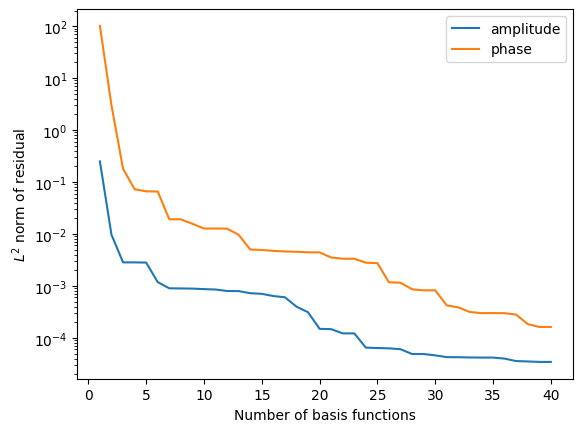

In [35]:
N_max = 40
errors = []
for n in np.arange(1, N_max + 1, 1):
    errors.append(modeling_error(n))

plt.semilogy(np.arange(1, N_max + 1, 1), errors, label=['amplitude','phase'])
plt.legend()
plt.xlabel('Number of basis functions')
plt.ylabel(r'$L^{2}$ norm of residual');

Looks like $n=7$ was pretty reasonable!

#### step 3b: computing basis coefficients with Empirical Interpolant Method

While SVD finds a basis that best captures the features of the data set, it is not necessarily the most *computationally efficient*. As a result, an alternative to SVD that is often used in the surrogate modeling community is the Empirical Interpolant Method (EIM). Akin to how SVD provides a model for $h_{(\ell,m)}(t)$ as
$$
h_{(\ell,m)}(t)^{\mathrm{SVD}}=\sum\limits_{i=1}^{N}c_{i}(\vec{\Lambda})u_{i}(t),
$$
EIM also models the strain as a sum of weights against basis functions, but instead of using the projection coefficients, EIM instead uses waveform evaluations at specific points in time that are deemed more important than others, so one has
$$
h_{(\ell,m)}(t)^{\mathrm{EIM}}=\sum\limits_{i=1}^{N}h(T_{i};\vec{\Lambda})B_{i}(t),
$$
where the $B_{i}(t)$ basis functions are just linear combinations of the $u_{i}(t)$ basis functions resulting from SVD.

These empirical interpolant nodes $T_{i}$ are chosen using a simple greedy algorithm, illustrated through the following:

<img src="images/EIMAlgo.png" width="600" height="200">

Effectively what this does is:
1. Choose $T_{1}$ as the time at which $e_{1}(t)$ achieves its maximum value
2. Chooe every subsequent $T_{i}$ to be the time at which the residual between $e_{i}(t)$ and the model of $e_{i}(t)$ using $\{e_{j}(t)\}$ for $j<i$ is maximized

To use EIM, we can rely on Chad Galley's `rompy` (reduced order modeling) package (see [arXiv:1308.3565](https://arxiv.org/pdf/1308.3565) for more!):

In [36]:
import rompy

In [37]:
A_eim = rompy.EmpiricalInterpolant(A_basis_set.transpose())
phi_eim = rompy.EmpiricalInterpolant(phi_basis_set.transpose())

So where did EIM place the time nodes $t_{i}$?

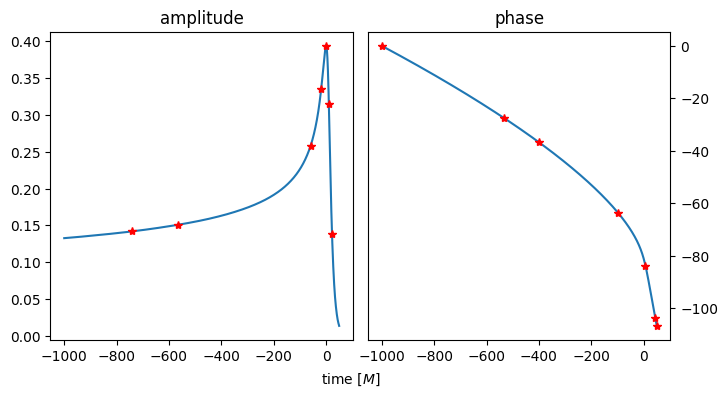

In [38]:
fig, axis = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
plt.subplots_adjust(wspace=0.05)

axis[0].plot(t_common, As[idx_test])
axis[0].plot(t_common[A_eim.indices], As[idx_test][A_eim.indices], 'r*')

axis[1].plot(t_common, phis[idx_test])
axis[1].plot(t_common[phi_eim.indices], phis[idx_test][phi_eim.indices], 'r*')

axis[1].yaxis.tick_right()
axis[0].set_title('amplitude')
axis[1].set_title('phase')
fig.text(0.5, 0.0, r'time $[M]$', ha='center');

Interesting! Many points are clustered near the merger, which is maybe what we'd expect since this is the most complicated part of the waveform!

So how does the modeling actually compare to SVD then?

In [39]:
A_approx_EIM = np.dot(A_eim.B.transpose(), As[idx_test][A_eim.indices])
phi_approx_EIM = np.dot(phi_eim.B.transpose(), phis[idx_test][phi_eim.indices])

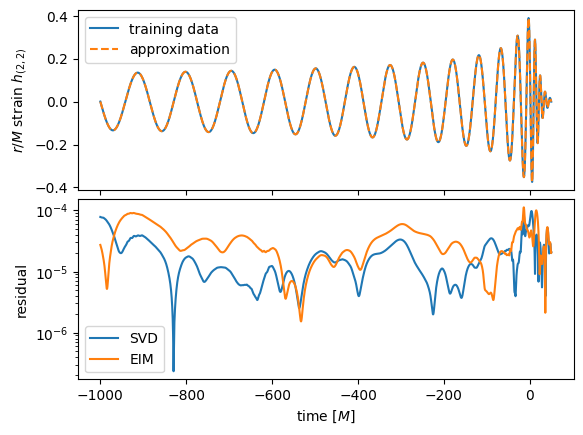

In [40]:
fig, axis = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=0.05)

axis[0].plot(t_common, hs[idx_test].data[:,hs[idx_test].index(2,2)].imag, label='training data')
axis[0].plot(t_common, A_approx_EIM * np.exp(1j * phi_approx_EIM).imag, ls='--', label='approximation')
axis[1].semilogy(t_common, abs(hs[idx_test].data[:,hs[idx_test].index(2,2)] - A_approx * np.exp(1j * phi_approx)), label='SVD')
axis[1].semilogy(t_common, abs(hs[idx_test].data[:,hs[idx_test].index(2,2)] - A_approx_EIM * np.exp(1j * phi_approx_EIM)), label='EIM')
axis[0].legend()
axis[1].legend()
axis[0].set_ylabel(r'$r/M$ strain $h_{(2,2)}$')
axis[1].set_xlabel(r'time $[M]$')
axis[1].set_ylabel('residual');

Great! The residual is identical. But note that *we've only used the waveform evaluated at seven time points* to obtain the EIM result, unlike the 10,500 used for SVD! This is the beauty of reduced order modeling. While it may not be important for this somewhat trivial example, when dealing with a lot of waveform data for a large parameter space this can make a big difference.

#### step 4a: interpolating coefficients across parameter space with splines

At this point, we now have two data matrices for the amplitudes and phases from our EIM, visualized below.

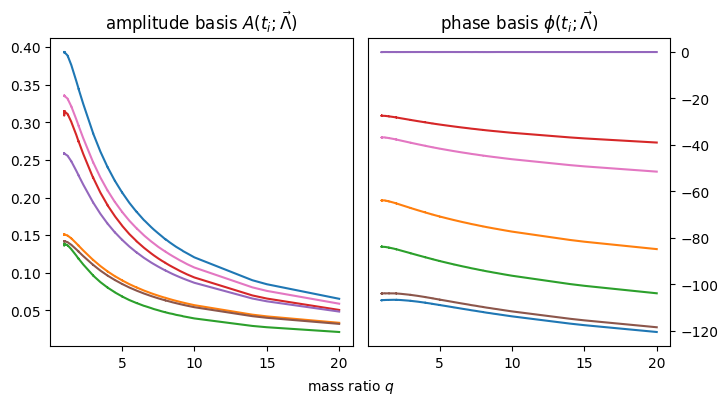

In [41]:
fig, axis = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
plt.subplots_adjust(wspace=0.05)
axis[0].plot(qs, As[:,A_eim.indices])
axis[1].plot(qs, phis[:,phi_eim.indices])
axis[1].yaxis.tick_right()
axis[0].set_title(r'amplitude basis $A(t_{i};\vec{\Lambda})$')
axis[1].set_title(r'phase basis $\phi(t_{i};\vec{\Lambda})$')
fig.text(0.5, 0.0, r'mass ratio $q$', ha='center');

Each of these coefficients look fairly smooth across parameter space, so let's simply try modeling them with splines.

In [42]:
from scipy.interpolate import splrep, splev

In [43]:
A_eim_spline = [splrep(qs, As[:,A_eim.indices][:,i], k=2) for i in range(len(A_eim.indices))]
phi_eim_spline = [splrep(qs, phis[:,phi_eim.indices][:,i], k=2) for i in range(len(phi_eim.indices))]

Easy enough! Now we can evaluate them.

In [44]:
q = 12
A_eim_spline_eval = np.array([splev(q, A_eim_spline[i]) for i in range(len(A_eim.indices))])
phi_eim_spline_eval = np.array([splev(q, phi_eim_spline[i]) for i in range(len(phi_eim.indices))])
h_approx = np.dot(A_eim.B.transpose(), A_eim_spline_eval) * np.exp(1j * np.dot(phi_eim.B.transpose(), phi_eim_spline_eval))

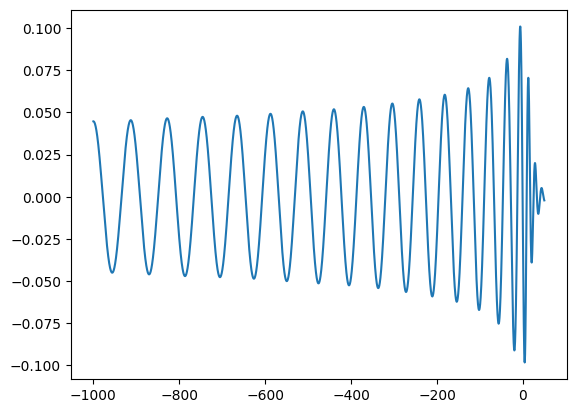

In [45]:
plt.plot(t_common, h_approx);

Looks pretty reasonable! But does it fit in with our plot from before?

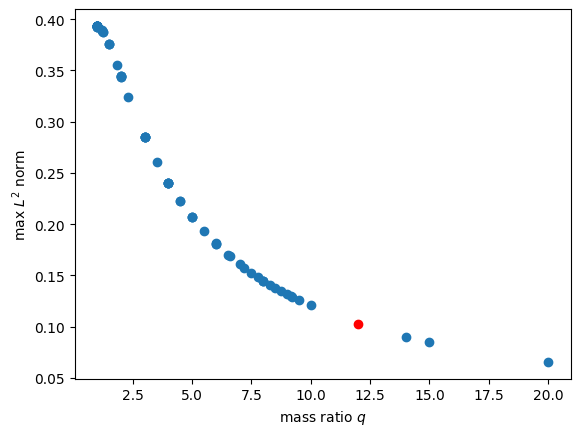

In [46]:
plt.scatter(qs, [max(abs(h.data[:,h.index(2,2)])) for h in hs])
plt.scatter(q, max(abs(h_approx)), color='red')
plt.xlabel('mass ratio $q$')
plt.ylabel('max $L^{2}$ norm');

Not bad! And to really show things off, we can even recreate the full waveform plot from earlier.

/var/folders/63/h_06fwvj5_v_gyn7d32k4dbm0000gn/T/ipykernel_17041/1584272471.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


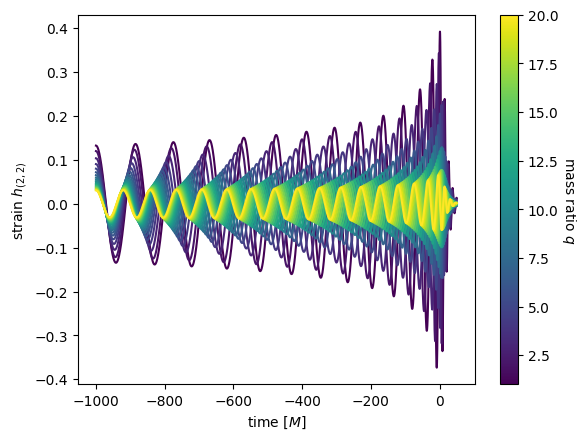

In [47]:
fine_qs = np.arange(1, 20 + 1, 1)

norm = colors.Normalize(vmin=min(fine_qs), vmax=max(fine_qs))
cmap = cm.get_cmap('viridis')

for q in fine_qs:
    A_eim_spline_eval = np.array([splev(q, A_eim_spline[i]) for i in range(len(A_eim.indices))])
    phi_eim_spline_eval = np.array([splev(q, phi_eim_spline[i]) for i in range(len(phi_eim.indices))])
    h_approx = np.dot(A_eim.B.transpose(), A_eim_spline_eval) * np.exp(1j * np.dot(phi_eim.B.transpose(), phi_eim_spline_eval))
    plt.plot(t_common, h_approx, color=cmap(norm(q)))
plt.xlabel(r'time $[M]$')
plt.ylabel(r'strain $h_{(2,2)}$')

res = plt.scatter([None]*len(fine_qs), [None]*len(fine_qs), c=np.array(fine_qs), vmin=min(fine_qs), vmax=max(fine_qs), cmap='viridis')
c = plt.colorbar(res)
c.set_label('mass ratio $q$', rotation=270, labelpad=14);

Wow! Our first surrogate model!

### Future challenges:
* Is there a better way to understand our model's errors?
* Can you think of something better to use than splines for modeling the $A(t_{i};\vec{\Lambda})$ and $\phi(t_{i};\vec{\Lambda})$ functions? Maybe Gaussian Process Regression? (see below for how to do it!)
* Can you model the other modes of the waveform?
* Can you include spins? (avoid precession to start, as this requires a bit more work (⭐️ Bonus: why is precession harder? are you up for the challenge?))
* Can you make your model autodifferentiable with `jax`?

### Let's tackle a challenge! Let's incorporate Gaussian Process Regression!

So what even is Gaussian Process Regression (GPR)? The idea behind GPR is nicely explained through the following four images, courtesy of N. Durrande and R. Le Riche.

<img src="images/GPR1.png" width="400" height="200">

1. Let's imagine we've observed some function $f(x):\mathbb{R}\rightarrow\mathbb{R}$ at a series of data points $x_{i}\in\mathbb{R}$ (note that we could also have $f(x):\mathbb{R}^{n}\rightarrow\mathbb{R}^{m}$ for arbitrary $n,m\in\mathbb{N}$). There's an infinite number of functions that we could consider that pass through these data points. For example, perhaps the simplest function we could construct is just connecting these points with straight lines. However, nature (for whatever reason) often yields functions (descriptions of reality) that are smooth! So that simple example probably isn't that good of a guess for what our underlying function really is. Instead, a better thing to do might be to assert some likelihood of our function's value from one point to the next based on the the values of those two input points, i.e., defining some *kernel* $ker(x_{i},x_{j}):\mathbb{R}^{2}\rightarrow\mathbb{R}$ (or two-point function if you remember QFT) which controls what our possible functions can look like. If our kernel is the identity, $ker(x_{i},x_{j})=\delta_{i,j}$, then what we're asserting is that we impose no restrictions on our function's values from one point to the next, since those points are completely uncorrelated! However, if we assume a kernel with more structure, like the Radial Basis Function (RBF) kernel:
$$
ker_{\mathrm{RBF}}(x_{i},x_{j})=\exp\left(-\frac{1}{2}(x_{i}-x_{j})\right)
$$
then we're asserting that if our points are closer together, our function is more constrained in what value it can take when moving from one point to the next. Consequently, it should be much smoother!

<img src="images/GPR2.png" width="400" height="200">

2. With the RBF kernel from step 1, we can now draw the possible functions associated with this kernel, as shown above. But clearly some of these are better than others! In particular, *we should only consider functions which pass through our data points!*

<img src="images/GPR3.png" width="400" height="200">

3. Much better! And now that we have our set of valid functions with respect to our chosen kernel and input data, we can now describe our underlying function as the mean of these functions with variance matching the variance of these functions!

<img src="images/GPR4.png" width="400" height="200">

4. This is what it means to model data with GPR, and is what we'll attempt below. The only other thing to note is that GPR works much better when provided data with zero mean and unit variance, so often when modeling data with GPR we first perform a linear fit, subtract that from our data, and then scale our data so that it has unit variance.

Ok, let's try incorporating GPR now! We'll do so by simply trying to model our basis coefficients $A(t_{i};\vec{\Lambda})$ and $\phi(t_{i};\vec{\Lambda})$ with GPR instead of splines.

In [48]:
import utils_GPR # this contains some wrappers for scikit-learns GPR functions, check it out if you're curious!

In [49]:
A_GPR = []
for i in range(len(A_eim.indices)):
    GPR = utils_GPR.GPRFitter()
    GPR.fit(
        np.log10(np.array(qs)).reshape(-1, 1),
        np.array(As[:,A_eim.indices][:,i]).reshape(-1, 1)
    )
    A_GPR.append(GPR)

phi_GPR = []
for i in range(len(phi_eim.indices)):
    GPR = utils_GPR.GPRFitter()
    GPR.fit(
        np.log10(np.array(qs)).reshape(-1, 1),
        np.array(phis[:,phi_eim.indices][:,i]).reshape(-1, 1)
    )
    phi_GPR.append(GPR)

(⭐️ Bonus: why do we need to use $\log(q)$ instead of $q$ for the training data?).

We can evaluate this, with the error on its prediction, via, e.g.,

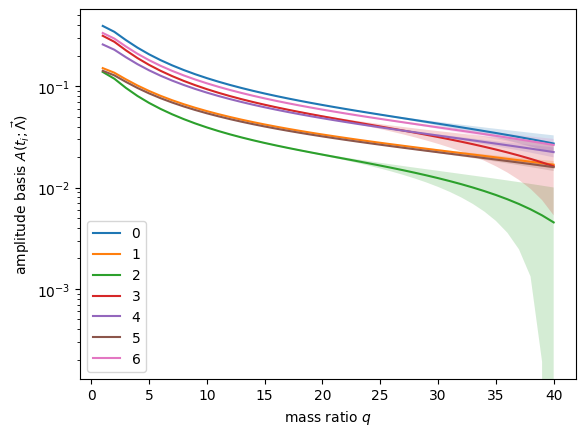

In [50]:
fine_qs = np.arange(1, 40 + 1, 1)

for i in range(len(A_eim.indices)):
    A_GPR_evals = []
    for q in fine_qs:
        A_GPR_eval = np.array(A_GPR[i]([np.log10(q)], return_std=True, raise_warning=False)[0])
        A_GPR_eval_std = np.array(A_GPR[i]([np.log10(q)], return_std=True, raise_warning=False)[1])
        A_GPR_evals.append([A_GPR_eval, A_GPR_eval_std])
    A_GPR_evals = np.array(A_GPR_evals)
    
    plt.plot(fine_qs, A_GPR_evals[:,0], label=f'{i}')
    plt.fill_between(fine_qs, (A_GPR_evals[:,0] - A_GPR_evals[:,1]).flatten(), (A_GPR_evals[:,0] + A_GPR_evals[:,1]).flatten(), alpha=0.2)
plt.legend()
plt.yscale('log')
plt.xlabel(r'mass ratio $q$')
plt.ylabel(r'amplitude basis $A(t_{i};\vec{\Lambda})$');

Dang! It looks like GPR is very confident in it's prediction of the amplitude coefficients, with the only noticeable variance being when we move pretty far outside of it's training regime (i.e., $q>20$).

But how'd we do with the waveforms?

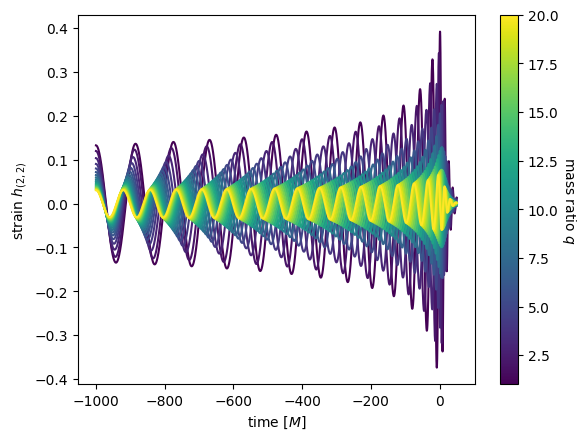

In [83]:
fine_qs = np.arange(1, 20 + 1, 1)

norm = colors.Normalize(vmin=min(fine_qs), vmax=max(fine_qs))
cmap = cm.get_cmap('viridis')

for q in fine_qs:
    A_GPR_eval = np.array([A_GPR[i]([np.log10(q)], raise_warning=False) for i in range(len(A_eim.indices))])
    phi_GPR_eval = np.array([phi_GPR[i]([np.log10(q)], raise_warning=False) for i in range(len(phi_eim.indices))])
    h_approx = np.dot(A_eim.B.transpose(), A_GPR_eval) * np.exp(1j * np.dot(phi_eim.B.transpose(), phi_GPR_eval))
    plt.plot(t_common, h_approx.real, color=cmap(norm(q)))
plt.xlabel(r'time $[M]$')
plt.ylabel(r'strain $h_{(2,2)}$')

res = plt.scatter([None]*len(fine_qs), [None]*len(fine_qs), c=np.array(fine_qs), vmin=min(fine_qs), vmax=max(fine_qs), cmap='viridis')
c = plt.colorbar(res)
c.set_label('mass ratio $q$', rotation=270, labelpad=14);

Nice!

And how does it compare to using splines? To really test this, let's look at how the model extrapolates to high $q$.

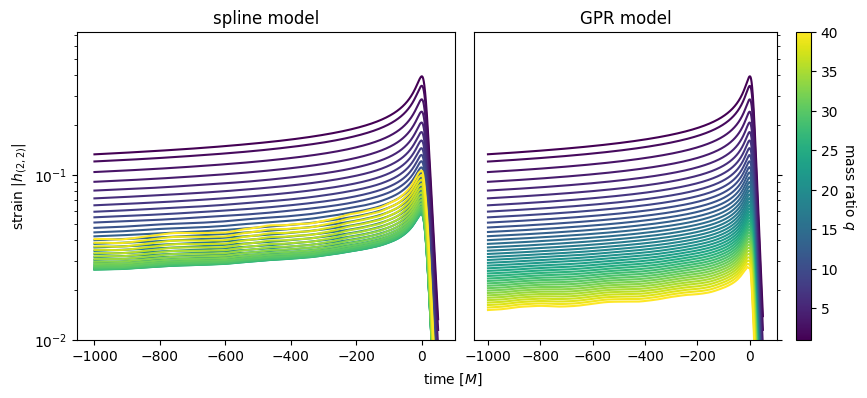

In [52]:
fine_qs = np.arange(1, 40 + 1, 1)

norm = colors.Normalize(vmin=min(fine_qs), vmax=max(fine_qs))
cmap = cm.get_cmap('viridis')

fig, axis = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05)

for q in fine_qs:
    A_eim_spline_eval = np.array([splev(q, A_eim_spline[i]) for i in range(len(A_eim.indices))])
    phi_eim_spline_eval = np.array([splev(q, phi_eim_spline[i]) for i in range(len(phi_eim.indices))])
    h_approx = np.dot(A_eim.B.transpose(), A_eim_spline_eval) * np.exp(1j * np.dot(phi_eim.B.transpose(), phi_eim_spline_eval))
    axis[0].plot(t_common, abs(h_approx), color=cmap(norm(q)))

for q in fine_qs:
    A_GPR_eval = np.array([A_GPR[i]([np.log10(q)], raise_warning=False) for i in range(len(A_eim.indices))])
    phi_GPR_eval = np.array([phi_GPR[i]([np.log10(q)], raise_warning=False) for i in range(len(phi_eim.indices))])
    h_approx = np.dot(A_eim.B.transpose(), A_GPR_eval) * np.exp(1j * np.dot(phi_eim.B.transpose(), phi_GPR_eval))
    axis[1].plot(t_common, abs(h_approx), color=cmap(norm(q)))

axis[1].yaxis.tick_right()

res = plt.scatter([None]*len(fine_qs), [None]*len(fine_qs), c=np.array(fine_qs), vmin=min(fine_qs), vmax=max(fine_qs), cmap='viridis')
c = plt.colorbar(res)
c.set_label('mass ratio $q$', rotation=270, labelpad=14)
axis[0].set_yscale('log')
axis[0].set_ylim(1e-2)

axis[0].set_ylabel(r'strain $|h_{(2,2)}|$')
fig.text(0.5, 0.0, r'time $[M]$', ha='center')

axis[0].set_title('spline model')
axis[1].set_title('GPR model');

Wow! It looks like GPR is extrapolating much better than the spline model, cool! (Note that this spline behavior is somewhat expected since we used a degree 2 polynomial, so it should eventually "ramp up" for high $q$).